중간고사: 컴퓨터 비전 문제
=========================

목표: 간단한 컨볼루션 신경망(CNN)을 사용하여 이미지 분류 작업을 수행합니다. 이 과제에서는 Fashion-MNIST 데이터셋을 사용합니다. Pytorch로 구현하세요.
-----------------------------------------------------------------------------------------------------------------------------------------------

데이터셋:

Fashion-MNIST는 의류와 관련된 이미지로 구성된 데이터셋으로, 각 이미지는 28x28 픽셀의 그레이스케일 이미지입니다. 데이터셋에는 10개의 클래스가 있으며, 각 클래스는 다른 유형의 패션 아이템(예: 티셔츠, 바지, 풀오버, 드레스 등)을 나타냅니다.

과제:

데이터 분석:
torchvision module에서 제공하는 FashionMNIST를 활용해야 합니다 (전체 데이터)
이미지 데이터의 형태와 클래스 레이블을 시각적으로 탐색하고 분석합니다.


모델 구축 및 훈련:
간단한 CNN 모델을 구축합니다. 모델은 적어도 한 개의 컨볼루션 레이어와 풀링 레이어를 포함해야 합니다.
모델을 컴파일하고, 적절한 손실 함수와 최적화 알고리즘을 선택합니다.
훈련 데이터를 사용하여 모델을 훈련시키고, 훈련 과정에서의 손실과 정확도를 모니터링합니다.


모델 평가 및 결과 분석:
테스트 데이터셋을 사용하여 모델을 평가하고, 최종 정확도를 보고합니다.
잘못 분류된 이미지들을 분석하고, 어떤 클래스가 모델에 의해 가장 잘못 분류되었는지를 식별합니다.

작업 커널(환경)
==============
pytion 3.10.13

설치 환경 및 라이브러리 설치
===========================

In [47]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

%pip install torchvision            # torchvision 라이브러리 설치
%pip install torchinfo              # torchinfo 라이브러리 설치
%pip install pytorchcv              # pytorchcv 라이브러리 설치

# 데이터 셋을 읽어오는 모듈
import numpy as np

# CNN 구성
import torch                        # pytorch import 진행
import torch.nn as nn               # nn 정의
import torchvision                  # torchvision
import pytorchcv                    # py
import torch.optim as optim         # 최적화 구현 패키지
import torch.nn.functional as F
import pylab
import matplotlib.pyplot as plt     # pyplot = 시각화
from torchinfo import summary       # torchinfo = 모델의 구조 확인

from pytorchcv import load_mnist, train, plot_results, plot_convolution, display_dataset, validate

--2024-04-19 03:12:41--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6540 (6.4K) [text/plain]
Saving to: ‘pytorchcv.py.5’

pytorchcv.py.5      100%[===================>]   6.39K  --.-KB/s    in 0.001s  

2024-04-19 03:12:41 (7.48 MB/s) - ‘pytorchcv.py.5’ saved [6540/6540]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Fashion - MNIST 데이터 셋을 로드
===============================
데이터 셋을 로드한 결과로 두 개의 데이터 셋을 생성
하나는 훈련 데이터셋인 train_data, 다른 하나는 테스트 데이터셋인 test_data에 저장

In [48]:
# load_minst의 batch_size를 64로 지정, train_data와 test_data로 분할
train_data = load_mnist(batch_size=64)
test_data = load_mnist(batch_size=64)

# FashionMNIST로 정상적인 데이터를 가져왔음을 확인할 수 있음
print(type(data_train))
print(type(data_test))

<class 'torchvision.datasets.mnist.FashionMNIST'>
<class 'torchvision.datasets.mnist.FashionMNIST'>


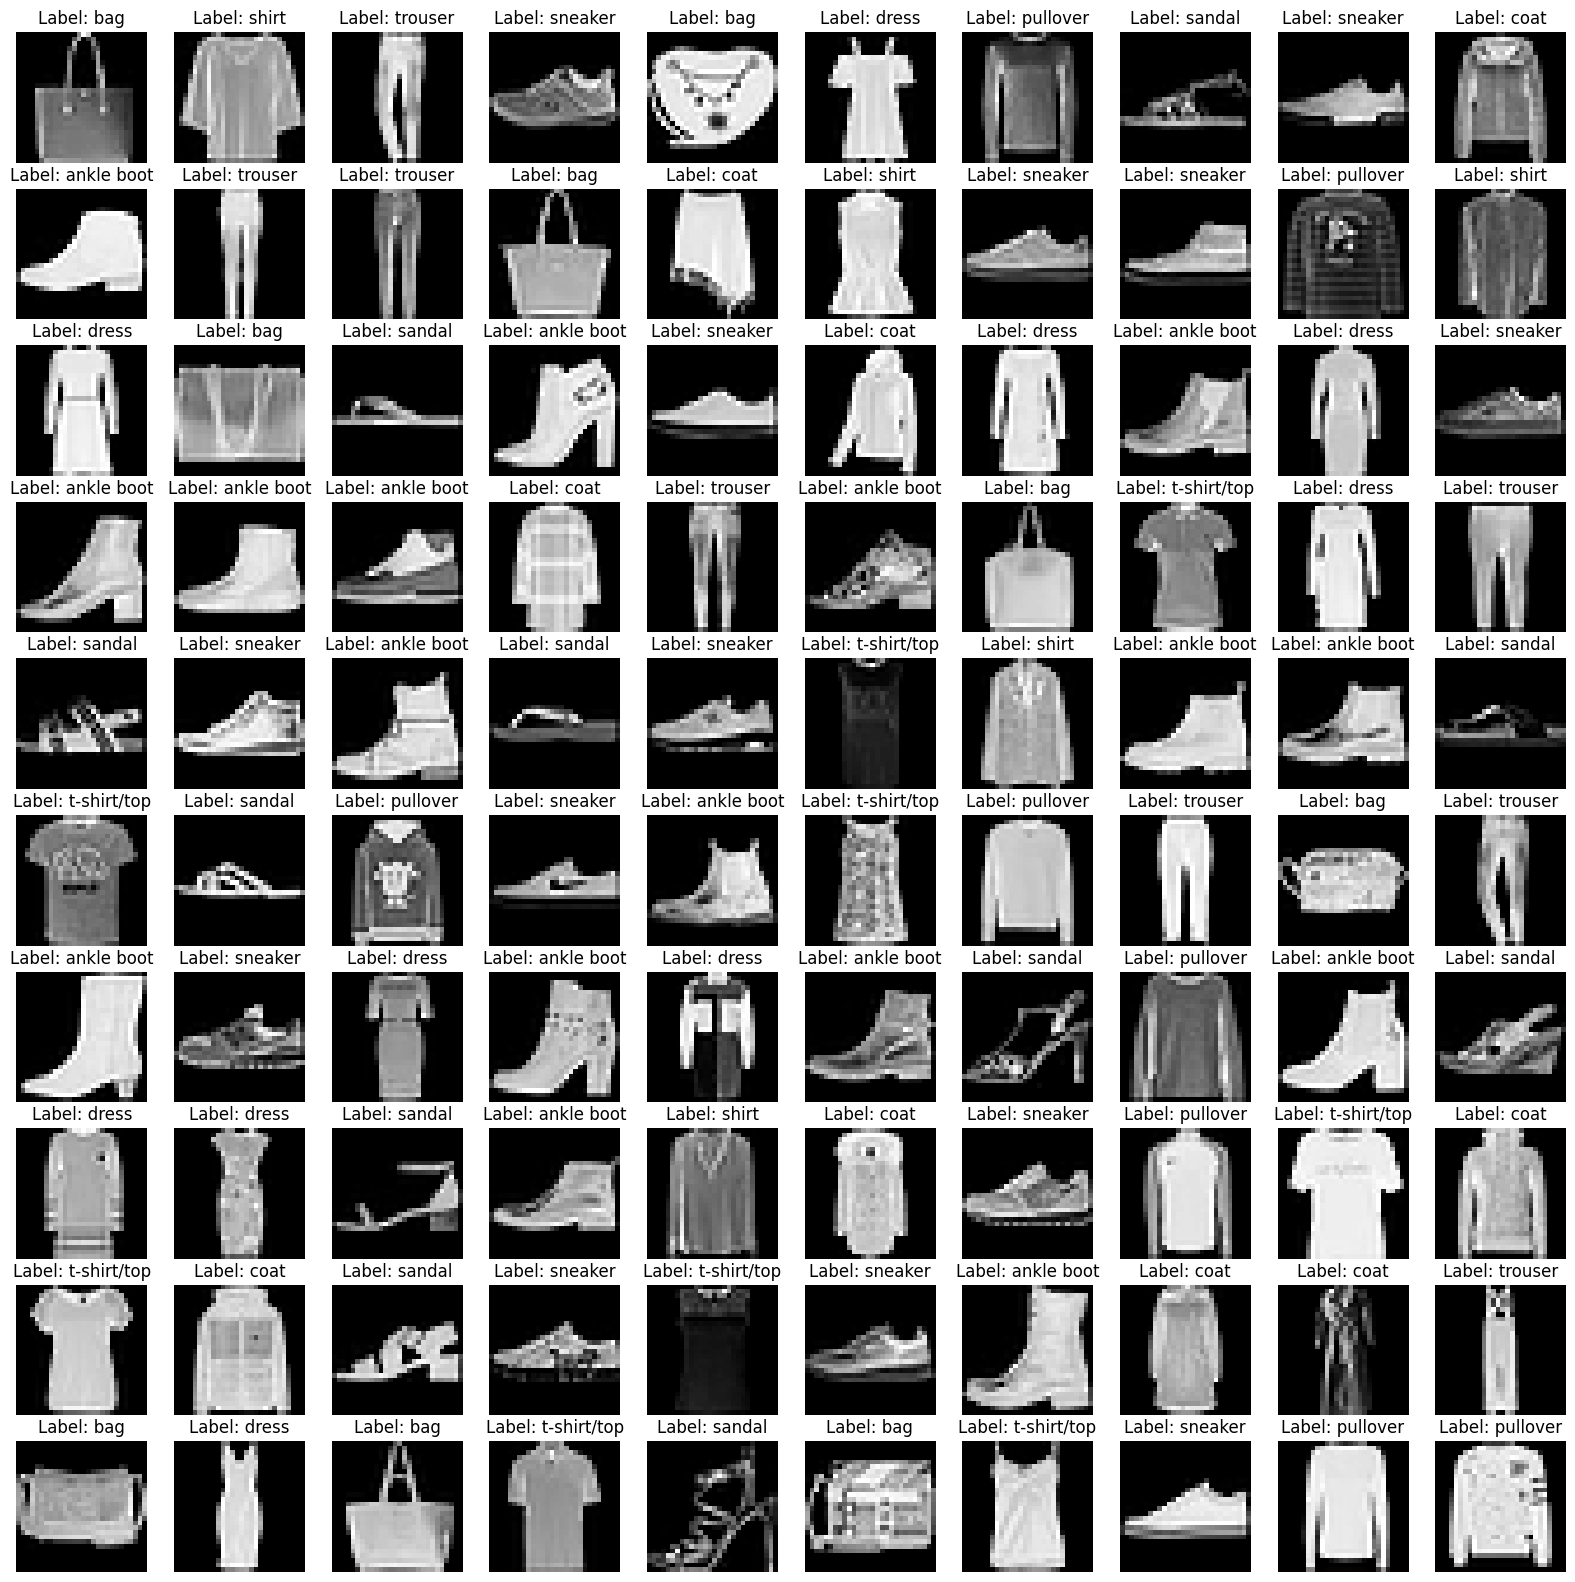

In [49]:
# 데이터 셋에 있는 10개의 클래스 유형을 정의
labels_map = { 0: "t-shirt/top", 1: "trouser", 2: "pullover", 3: "dress", 4: "coat", 5: "sandal", 6: "shirt", 7: "sneaker", 8: "bag", 9: "ankle boot"}


figure = plt.figure(figsize=(20, 20))               # 데이터 사이즈 지정
cols, rows = 10, 10                                 # 10 x 10 개의 샘플 이미지 데이터 출력

for i in range(1, cols * rows + 1): 
    sample_idx = torch.randint(len(data_train), size=(1,)).item() 
    img, label = data_train[sample_idx] 
    
    figure.add_subplot(rows, cols, i) 
    plt.title(f"Label: {labels_map[label]}") 
    plt.axis("off") 
    plt.imshow(img.squeeze(), cmap="gray") 

plt.show() 

# 10x10 격자 모양의 샘플 이미지를 시각화
# 각 반복마다 랜덤하게 데이터셋에서 이미지를 선택하고, 해당 이미지의 레이블을 확인하여 시각화
# figure.add_subplot을 사용하여 이미지의 레이블과 함께 이미지를 출력
# plt.imshow를 사용하여 이미지를 출력하며,  cmap="gray"로 설정하여 흑백 이미지로 출력
label_counts = {}

# 데이터 셋에서 각 클래스 별로 이미지의 개수를 계산하는 과정을 수행
#  반복에서는 이미지와 해당 이미지의 레이블을 가져옴
for image, label in data_train: 
    if label in label_counts: 
        label_counts[label] += 1                    # 가져온 레이블이 label_counts에 이미 존재하는 경우, 해당 클래스의 이미지 개수를 1 증가시킴
    else:  
        label_counts[label] = 1                     # 처음 발견된 클래스인 경우, 새로운 클래스를 label_counts에 추가하고 1로 초기화

# label_counts 딕셔너리의 항목들을 레이블 순서대로 정렬한 후, 이를 새로운 딕셔너리인 sorted_label_counts에 저장
sorted_label_counts = dict(sorted(label_counts.items()))
# 각 클래스 별로 몇 개의 이미지가 있는지 정렬된 형태로 확인할 수 있음

# labels 리스트에는 각 클래스의 이름이 순서대로 저장됨
# counts 리스트에는 각 클래스의 이미지 개수가 순서대로 저장됨
# 이 두 리스트는 각각 클래스 이름과 해당 클래스의 이미지 개수를 나타내며, 이 정보를 통해 데이터 셋의 클래스 분포를 시각화, 분석하는 데 사용
labels = [labels_map[label] for label in sorted_label_counts.keys()]  
counts = list(sorted_label_counts.values())  


CNN 모델 구축
=============
모델은 적어도 한 개의 컨볼루션 레이어와 풀링 레이어를 포함

In [50]:
import torch.nn as nn                                                            # torch.nn 모듈은 신경망을 구성하기 위한 다양한 클래스와 함수를 제공
%pip install torchsummary                                                        # torchsummary 라이브러리를 설치 / torchsummary : 신경망 모델의 요약 정보 제공
from torchsummary import summary 

class CNN_model(nn.Module):                                                      # CNN_model이라는 새로운 클래스를 정의하고, 이는 nn.module을 상속받음
    def __init__(self): 
        super(CNN_model, self).__init__() 
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5))    # 입력 채널 수는 1이고 출력 채널 수는 9이며, 커널 크기는 (5,5)인 컨볼루션 레이어를 정의
        self.max_pool = nn.MaxPool2d(kernel_size=2)                              # 풀링 레이어 추가
        self.flatten = nn.Flatten()                                              # 출력을 평탄화 하기 위한 레이
        self.fc = nn.Linear(5184,10)                                             # 입력 크기는 5184이고 출력 크기는 10인 완전 연결 레이어 정의

    def forward(self, x):                                                        # forward 메서드는 모델의 순전파를 정의
        if x.dim() == 5 and x.size(2) == 1:                                      # 입력 데이터가 5차원일 때는 2차원으로 축소하여 처리
            x = x.squeeze(2)                
        x = nn.functional.relu(self.conv(x))                                     # 컨볼루션 레이어를 통과한 후 ReLU 활성화 함수를 적용
        x = self.flatten(x)                                                      # ReLU의 출력을 평탄화
        x = nn.functional.log_softmax(self.fc(x),dim=1)                          # 평탄화 레이어를 통과한 후 완전 연결 레이어로 들어가기 전 로그 소프트맥스를 적용

        return x 

net = CNN_model()                                                                # CNN_model 클래스의 인스턴스를 생성

summary(net,input_size=(1,1,28,28))                                              # torchsummary.summary 함수를 사용하여 모델의 요약 정보를 출력 
# input_size 매개변수는 입력 데이터의 크기를 나타냄
# 여기서는 (1, 1, 28, 28) 크기의 이미지를 사용한다는 것을 의미하고, (채널 수, 높이, 너비)의 형태로 입력 크기를 지정
# 이를 통해 모델의 각 레이어의 구조와 출력 크기를 요약하여 확인할 수 있음

Note: you may need to restart the kernel to use updated packages.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 24, 24]             234
           Flatten-2                 [-1, 5184]               0
            Linear-3                   [-1, 10]          51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.20
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


PyTorch를 사용하여 신경망 모델을 학습하고 검증하는 과정을 구현
============================================================
모델을 컴파일하고, 적절한 손실 함수와 최적화 알고리즘을 선택

In [51]:

import torch 
from torch import optim
import torch.nn.functional as F

def train(model, train_loader, test_loader, epochs=5):                              # train 함수는 모델을 학습시키는 역할을 수행
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")           # 현재 사용 가능한 CUDA GPU가 있는 경우 GPU를 사용하고, 그렇지 않으면 CPU를 사용하기 위해 사용할 장치(device)를 선택
    model.to(device)                                                                # 선택한 장치에 모델을 이동시
    optimizer = optim.Adam(model.parameters(), lr=0.001)                            # Adam 최적화 알고리즘을 사용하여 모델의 파라미터를 업데이트하는 optimizer를 초기화하고, 학습률(learning rate)은 0.001로 설정
    criterion = torch.nn.CrossEntropyLoss() 
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'val_acc': [], 'val_loss': []}
    
    # 에폭 수만큼 반복하며, 학습 시에는 model.train()을 호출하여 모델을 학습 모드로 설정하고, 평가 시에는 model.eval()을 호출하여 평가 모드로 설정

    try:
        for epoch in range(epochs):
            model.train()
            train_loss, train_correct, train_total = 0, 0, 0
            for data, target in train_loader: 
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                if output is None:
                    print("Warning: Model output is None.")
                    continue
                
                loss = criterion(output, target) 
                if loss is None:
                    print("Warning: Loss computation returned None.")
                    continue
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()                                             # 정확도와 손실을 기록
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
            
            train_loss /= len(train_loader.dataset)
            train_acc = 100. * train_correct / train_total
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            
            model.eval()
            test_loss, test_correct, test_total = 0, 0, 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    if output is None:
                        print("Warning: Model output is None during evaluation.")
                        continue
                    
                    loss = criterion(output, target)
                    if loss is None:
                        print("Warning: Loss computation returned None during evaluation.")
                        continue
                    
                    test_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    test_total += target.size(0)
                    test_correct += (predicted == target).sum().item()
            
            test_loss /= len(test_loader.dataset)
            test_acc = 100. * test_correct / test_total
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)

            
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        
    except Exception as e: 
        print(f"An error occurred: {e}")
        return None
    
    return history 

훈련 데이터를 사용하여 모델을 훈련시키고, 훈련 과정에서의 손실과 정확도를 모니터링
===============================================================================

Epoch 1/10: Train Loss: 0.0076, Train Acc: 83.07%, Test Loss: 0.0064, Test Acc: 85.56%
Epoch 2/10: Train Loss: 0.0055, Train Acc: 87.51%, Test Loss: 0.0057, Test Acc: 87.13%
Epoch 3/10: Train Loss: 0.0049, Train Acc: 88.73%, Test Loss: 0.0054, Test Acc: 87.86%
Epoch 4/10: Train Loss: 0.0045, Train Acc: 89.64%, Test Loss: 0.0053, Test Acc: 88.28%
Epoch 5/10: Train Loss: 0.0042, Train Acc: 90.35%, Test Loss: 0.0052, Test Acc: 88.36%
Epoch 6/10: Train Loss: 0.0040, Train Acc: 90.92%, Test Loss: 0.0051, Test Acc: 88.54%
Epoch 7/10: Train Loss: 0.0037, Train Acc: 91.39%, Test Loss: 0.0051, Test Acc: 88.61%
Epoch 8/10: Train Loss: 0.0036, Train Acc: 91.87%, Test Loss: 0.0051, Test Acc: 88.84%
Epoch 9/10: Train Loss: 0.0034, Train Acc: 92.28%, Test Loss: 0.0051, Test Acc: 88.82%
Epoch 10/10: Train Loss: 0.0032, Train Acc: 92.61%, Test Loss: 0.0051, Test Acc: 88.99%


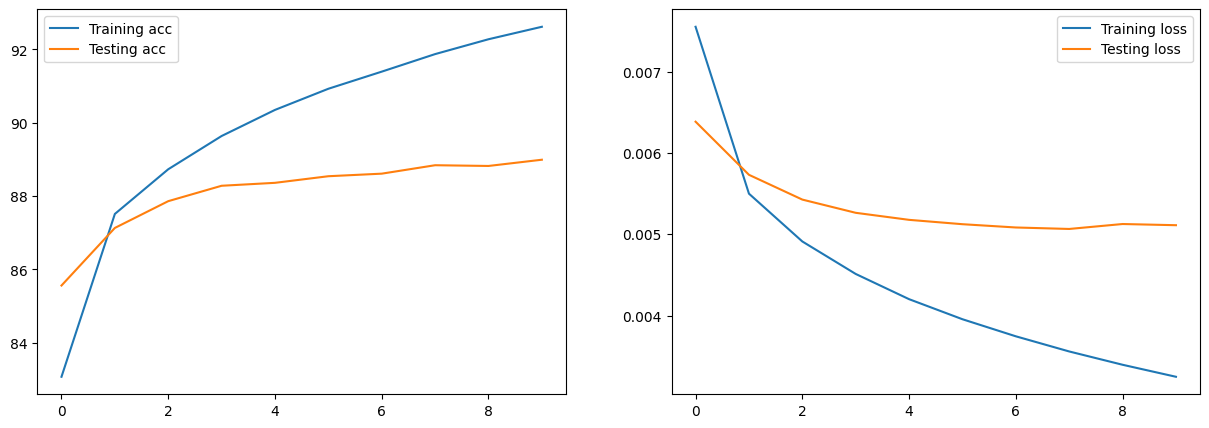

In [52]:
# train 함수를 호출하여 신경망 모델 net을 학습 
# 총 10 에폭(epoch) 동안 학습을 수행 hist 변수에 통계 정보를 저장
hist = train(net, train_loader, test_loader, epochs=10)

if hist is None:                                        # hist 변수가 None인지 확인
    print("Training did not return any history.") 

else:                                                   # hist 변수에 훈련 과정에서 기록된 정보가 있다면, 즉, train 함수가 정보를 반환했다면, plot_results 함수를 사용하여 훈련 과정에서 기록된 정보를 시각화
    plot_results(hist) 
# 훈련된 모델의 결과를 확인하고 시각화하는 데 사용됨
# 만약 훈련 과정에서 어떠한 정보도 얻지 못했다면, 그것 또한 확인 가

# 아래의 결과를 확인하면 여러 번의 학습을 진행해도 정확도가 87% ~ 88% 에서 머무르는 것을 확인함
# 또한 테스트 정확도가 떨어지는 부분이 있는 것도 확인함
# 적당한 학습 이후 추가적인 학습은 오히려 안좋은 결과를 도출해 낼 수 있음을 확인

테스트 데이터 셋을 사용하여 모델을 평가하고, 최종 정확도를 보고
=============================================================

In [53]:
# 모델을 평가하고 최종 정확도를 보고하는 과정
# 이 함수는 모델의 손실(loss)과 정확도(accuracy)를 반환
loss_val, acc_val = validate(net, test_loader) 
print("최종 모델 성능 결과")
print(f"Validation Loss: {loss_val:.4f}, Validation Accuracy: {acc_val:.4f}")
# loss_val은 검증 데이터셋에 대한 손실을 나타내며, acc_val은 검증 데이터셋에 대한 정확도를 나타냄

최종 모델 성능 결과
Validation Loss: 0.0051, Validation Accuracy: 0.8899


잘못 분류된 이미지들을 분석하고, 어떤 클래스가 모델에 의해 가장 잘못 분류되었는지를 식별
=====================================================================================

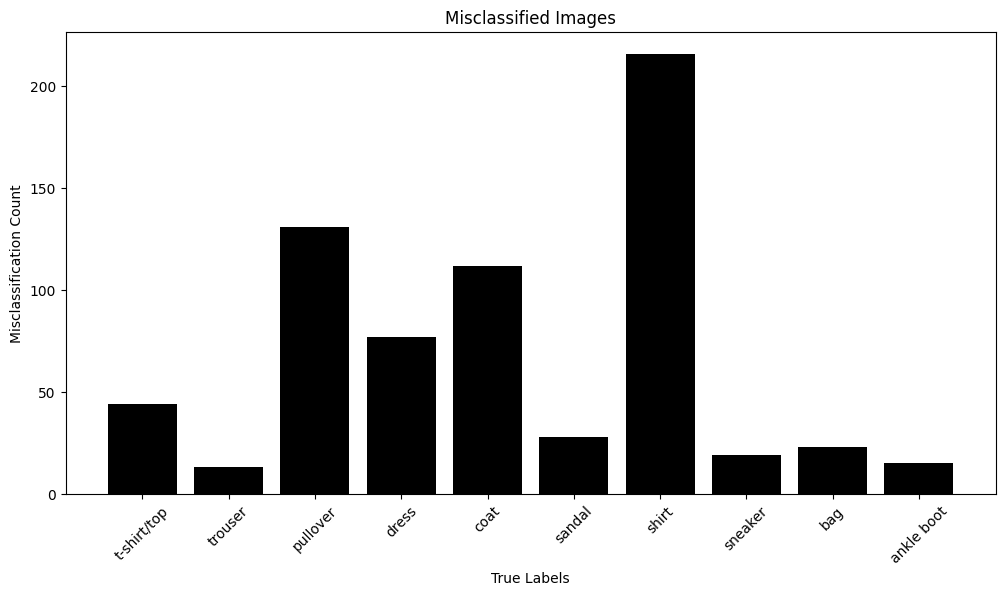

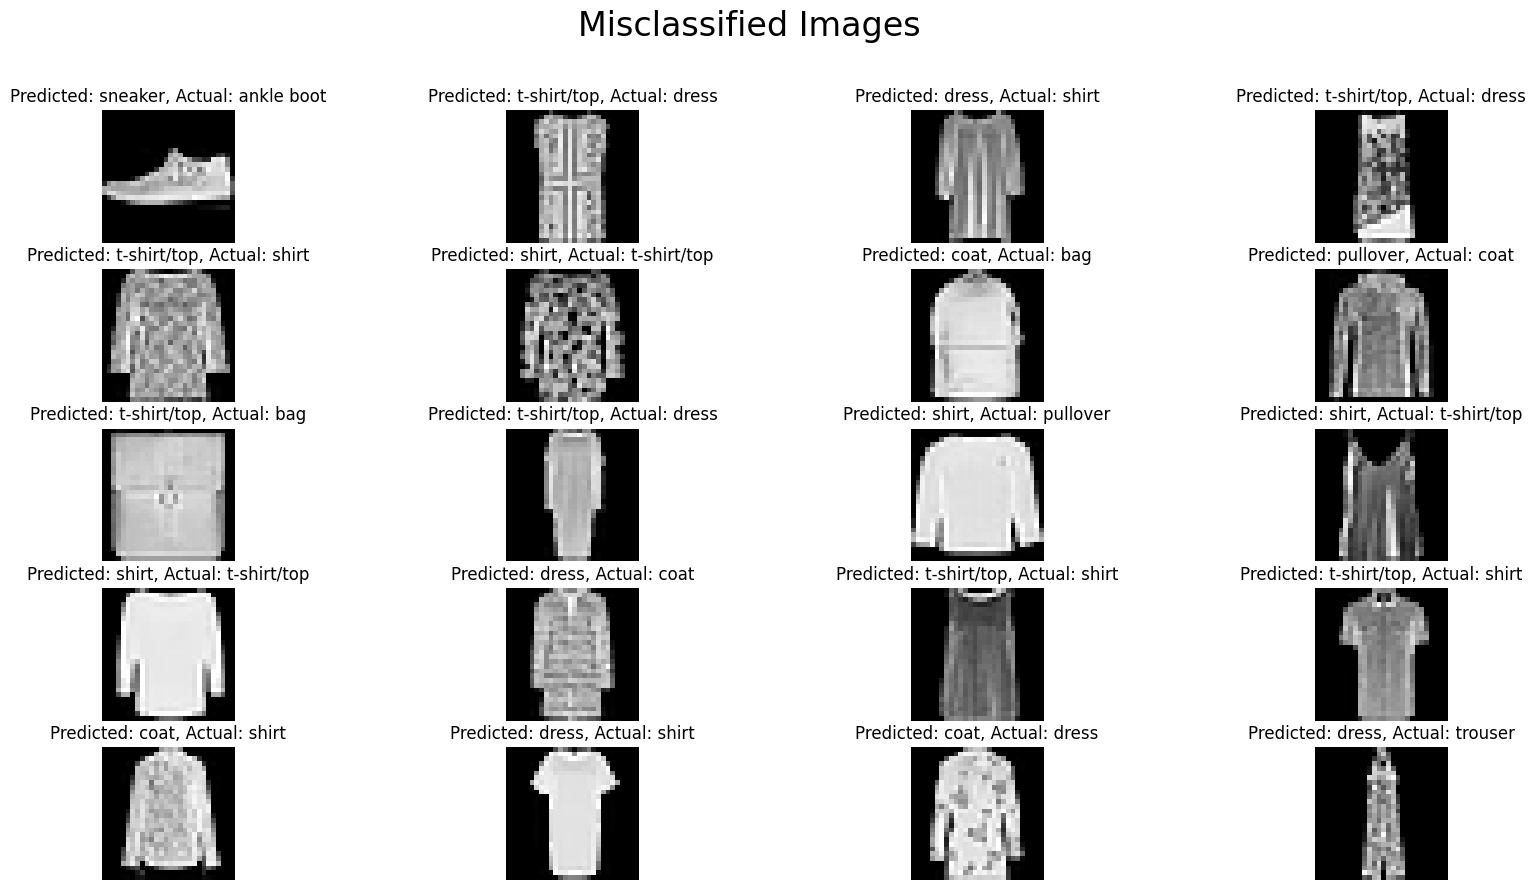

잘못 분류된 이미지들의 수:
shirt: 216 개
pullover: 131 개
coat: 112 개
dress: 77 개
t-shirt/top: 44 개
sandal: 28 개
bag: 23 개
sneaker: 19 개
ankle boot: 15 개
trouser: 13 개


In [54]:
import random

# 모델이 테스트 데이터 셋에서 어떤 클래스를 잘못 분류하는지 분석하고, 이를 시각화                       
def analyze_misclassified(net, dataloader, labels_map):                                            # 주어진 모델이 잘못 분류한 클래스를 분석하고 시각화
    default_device = "cpu"                                                                          # default_device 변수에는 기본 장치를 나타내는 문자열 "cpu"를 저장하고, 모델을 평가 모드로 설정
    net.eval()                                                                                      
    misclassified_counts = {label: 0 for label in range(len(labels_map))}                           # 각 클래스의 오류 분류 횟수를 저장하기 위해 딕셔너리를  초기화
    misclassified_images = []                                                                       # 잘못 분류된 이미지를 저장하기 위해 목록을 초기화

# 각 배치에서 모델의 출력을 계산하고, 예측된 클래스와 실제 클래스를 비교하여 잘못 분류된 인덱스를 찾음
    with torch.no_grad():  
        for features, labels in dataloader:
            features = features.to(default_device)
            labels = labels.to(default_device)

            outputs = net(features)                                                                # 예측된 출력을 계산하는 순방향 전달
            _, predicted = torch.max(outputs, 1)

            misclassified_idx = (predicted != labels).nonzero(as_tuple=False).squeeze()

            for idx in misclassified_idx:
                true_label = labels[idx].item()
                misclassified_counts[true_label] += 1
                misclassified_images.append((features[idx], predicted[idx].item(), true_label))

    
    class_names = [labels_map[i] for i in range(len(labels_map))]

# 각 클래스의 오류 분류 횟수를 표시하는 막대 그래프 생성
    labels = class_names  
    counts = list(misclassified_counts.values())

    plt.figure(figsize=(12, 6))
    plt.bar(labels, counts, color='black')
    plt.xlabel('True Labels')
    plt.ylabel('Misclassification Count')
    plt.title('Misclassified Images')
    plt.xticks(rotation=45)
    plt.show()

# 잘못 분류된 이미지 표시
    plt.figure(figsize=(20, 10))
    plt.suptitle("Misclassified Images", fontsize=24)
    random.shuffle(misclassified_images)
# 잘못 분류된 이미지 20개 출
    for i, (image, predicted, actual) in enumerate(misclassified_images[:20]):
        plt.subplot(5, 4, i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f"Predicted: {labels_map[predicted]}, Actual: {labels_map[actual]}", fontsize=12)
        plt.axis('off')

    plt.show()

    
    sorted_classes = sorted(misclassified_counts.items(), key=lambda x: x[1], reverse=True) 
        

# 잘못 분류된 이미지들의 수 출
    sorted_classes = sorted(misclassified_counts.items(), key=lambda x: x[1], reverse=True) 
    classes = [cls for cls, _ in sorted_classes]
    frequencies = [freq for _, freq in sorted_classes] 

    class_list = [labels_map[cls] for cls in classes] 
    print("잘못 분류된 이미지들의 수:")
    for cls, freq in zip(class_list, frequencies):
        print(f"{cls}: {freq} 개") 

# n 변수에는 테스트 데이터셋의 총 샘플 수를 나타내는 60000을 저장
# batch_size 변수에는 테스트 데이터 로더에 사용할 배치 크기를 나타내는 1000을 저장
n = 60000  
batch_size = 1000  

mini_test_loader = torch.utils.data.DataLoader(
    test_loader.dataset,
    batch_size=batch_size,
    sampler=torch.utils.data.SequentialSampler(range(int(n / 10))), 
    shuffle=False
)

# analyze_misclassified 함수를 호출하여 모델이 테스트 데이터 셋의 일부분을 사용하여 어떤 클래스를 잘못 분류하는지 분석
# 전체 테스트 데이터셋 대신에 일부분을 사용하여 모델의 분류 성능을 빠르게 분석 가능
analyze_misclassified(net, mini_test_loader, labels_map)


다음의 시각화 된 그래프를 통해 어떤 클래스의 오류가 가장 많이 발생하는지 확인할 수 있음
가장 많은 오류가 확인된 클래스는 Shirt
또한, 잘못 분류된 이미지 출력을 통해 어떤 이미지를 잘못 분석했는지 확인할 수 있음
마지막으로, 잘못 분류된 이미지들의 수 출력을 통해 Shirt 클래스가 가장 많은 오류가 발생했음을 재확인 할 수 있고, 그 수는 190임을 확인함
잘못 분류된 이미지들의 수와, 막대 그래프에서 보이는 오류 발생 순위가 일치함을 확인